In [2]:
import rasterio
import numpy as np
from rasterio import Affine, features
import geopandas as gpd
from shapely.geometry import mapping, shape, Polygon, MultiPolygon
from rasterio.features import shapes
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon, Rectangle
from shapely.ops import unary_union
from math import floor, ceil, sqrt

%matplotlib inline

In [3]:
structures = [Polygon([(-118.11755479999999352, 33.88250140000000243), (-118.11755440000000306, 33.88243099999999686), (-118.11752260000000092, 33.88243109999999803), (-118.11752250000000686, 33.88239380000000267), (-118.11755399999999838, 33.8823937000000015), (-118.11755399999999838, 33.88237469999999973), (-118.11774060000000475, 33.88237409999999983), (-118.11774119999999755, 33.88250080000000253), (-118.11755479999999352, 33.88250140000000243)]),
          Polygon([(-118.11772545899999898, 33.88249110600000336), (-118.11753415100000097, 33.88249256400010267), (-118.11753279799999916, 33.88236887600000102), (-118.1177241040000041, 33.88236741900009719), (-118.11772545899999898, 33.88249110600000336)]),
          Polygon([(-118.11773590743500506, 33.88238114719789706), (-118.11773858964400574, 33.88250695714410199), (-118.1175487765549974, 33.88250807870539916), (-118.11754818141599799, 33.88243800561979668), (-118.11752612456699296, 33.88243813592919906), (-118.11752581191700529, 33.88240132244899883), (-118.11754802755800142, 33.88240119120160188), (-118.1175478573219948, 33.88238114719050031), (-118.11773590743500506, 33.88238114719789706)])]

struct_names = ['A', 'B', 'C']

In [70]:
gdf = gpd.GeoDataFrame({'name': struct_names, 'geometry': structures}, crs='EPSG:4326')

#Save to csv
gdf.to_csv('structures.csv',index=False, header=False)

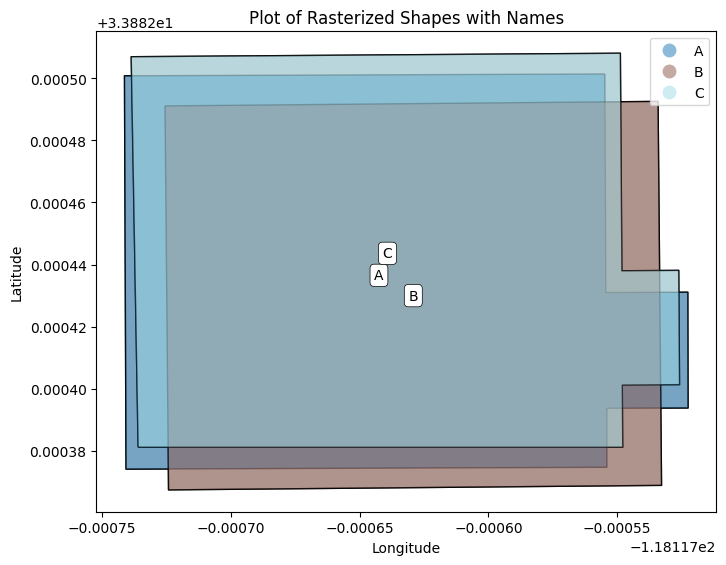

In [ ]:
gdf = gpd.GeoDataFrame({'name': struct_names, 'geometry': structures}, crs='EPSG:4326')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, edgecolor='black', facecolor='lightgray')

# Plot the GeoDataFrame with unique colors and transparency
gdf.plot(ax=ax, column='name', cmap='tab20', edgecolor='black', alpha=0.5, legend=True)


# Add labels for each shape
for idx, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['name'], fontsize=10, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))
    
# Customize plot
plt.title("Plot of Rasterized Shapes with Names")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



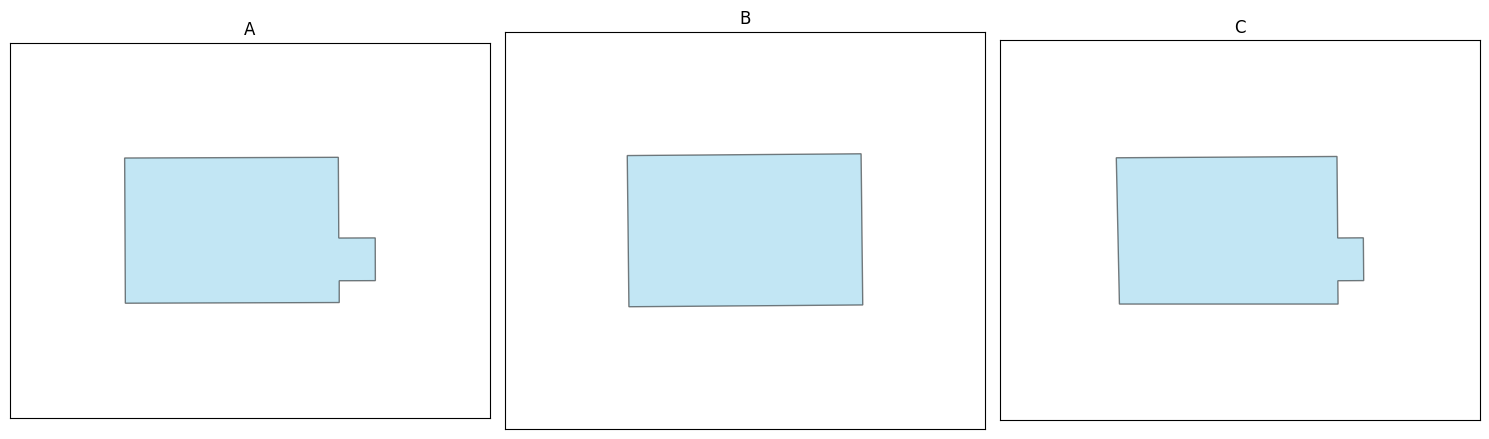

In [86]:
# Assuming 'gdf' is your GeoDataFrame containing the polygons with a 'name' column

# Plot each polygon in its own subplot
fig, axes = plt.subplots(1, len(structures), figsize=(15, 5))

for i, (shape, name) in enumerate(zip(structures, gdf['name'])):
    ax = axes[i]
    poly_patch = MplPolygon(list(shape.exterior.coords), edgecolor='black', facecolor='skyblue', alpha=0.5)
    ax.add_patch(poly_patch)

    # Set axis limits based on polygon bounds
    min_x, min_y, max_x, max_y = shape.bounds
    ax.set_xlim(min_x - 0.0001, max_x + 0.0001)
    ax.set_ylim(min_y - 0.0001, max_y + 0.0001)

    # Set the title using the 'name' attribute from the GeoDataFrame
    ax.set_title(f"{name}")  # Replace with whatever attribute you want to display
    # Remove x and y axis labels (ticks and labels)
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

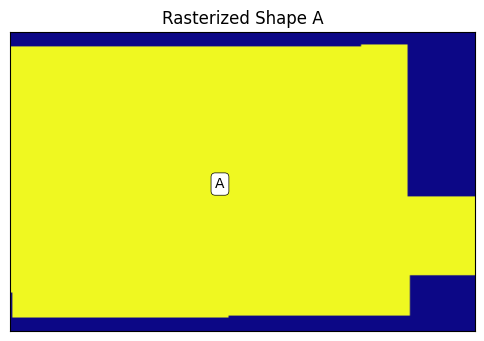

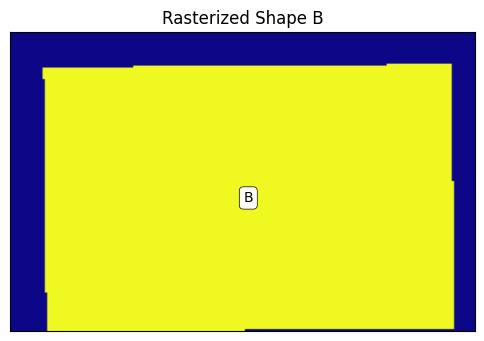

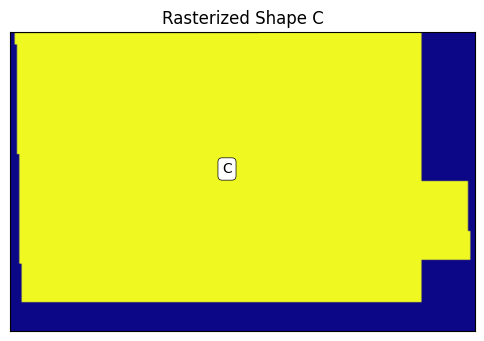

In [155]:
# Loop through each shape and rasterize individually

# Compute bounding box
xmin, ymin, xmax, ymax = (
    min(p.bounds[0] for p in structures), min(p.bounds[1] for p in structures),
    max(p.bounds[2] for p in structures), max(p.bounds[3] for p in structures)
)


# # Define raster resolution (degrees per pixel)
# nx, ny = 500, 500  # Higher resolution for better visualization
# xres = (xmax - xmin) / nx
# yres = (ymax - ymin) / ny

# Define degree-per-meter resolution at 33.88° latitude
lat_res = 0.0000009      # ~1 meter per pixel in latitude
lon_res = 0.00000109     # ~1 meter per pixel in longitude at 33.88° latitude

# Calculate raster dimensions
nx = int((xmax - xmin) / lon_res)
ny = int((ymax - ymin) / lat_res)

# Create affine transform for WGS 84 (still degrees, but 1-meter equivalent)
transform = Affine.translation(xmin, ymax) * Affine.scale(lon_res, -lat_res)

for i, (shape, name) in enumerate(zip(structures, gdf['name'])):
    # Create an empty raster for the current shape
    pa = np.zeros((ny, nx), dtype=np.uint8)
    
    # Rasterize only the current shape
    r = features.rasterize(
        [(mapping(shape), 1)],  # Assign pixel value 1 to this shape
        out_shape=(ny, nx),
        transform=transform
    )
    
    # Store rasterized shape in the raster array
    pa[r > 0] = 1  # Set rasterized pixels to 1 for visualization
    
    # Plot the raster for the current shape
    plt.figure(figsize=(6, 6))

    # Plot the rasterized shape
    plt.imshow(pa, cmap='plasma', origin='upper', extent=[xmin, xmax, ymin, ymax])
    
    # Add the label at the centroid
    centroid = shape.centroid
    plt.text(centroid.x, centroid.y, f"{name}", fontsize=10, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))
    
    
    plt.title(f"Rasterized Shape {name}")
    # Explicitly set axis limits (backing out further if necessary)
    #plt.xlabel("Longitude")
    #plt.ylabel("Latitude")
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

    plt.show()

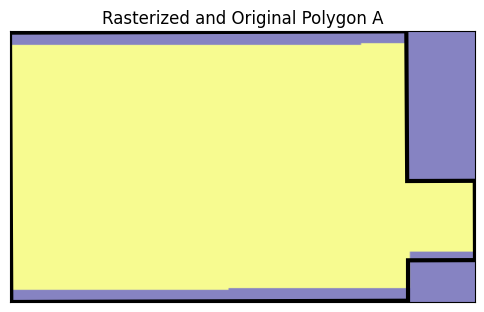

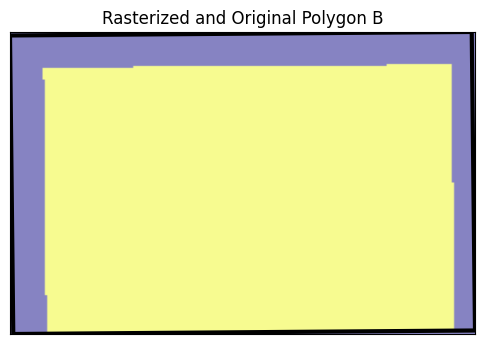

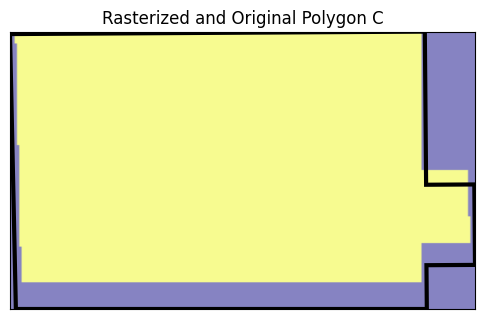

In [124]:
# Assuming 'structures' is a list of Shapely polygons, and 'pa' is the rasterized numpy array

# Loop through each shape and plot them individually
for i, (shape, name) in enumerate(zip(structures, gdf['name'])):
    # Create an empty raster for the current shape
    pa = np.zeros((ny, nx), dtype=np.uint8)
    
    # Rasterize only the current shape
    r = features.rasterize(
        [(mapping(shape), 1)],  # Assign pixel value 1 to this shape
        out_shape=(ny, nx),
        transform=transform
    )
    
    # Store rasterized shape in the raster array
    pa[r > 0] = 1  # Set rasterized pixels to 1 for visualization
    # Compute the bounding box for the current shape (you may already have this from earlier)
    xmin, ymin, xmax, ymax = shape.bounds
    
    # Create a new figure for each polygon
    plt.figure(figsize=(6, 6))

    # Plot the rasterized version of the current shape
    # Assuming 'pa' is the rasterized numpy array for the specific shape
    plt.imshow(pa, cmap='plasma', origin='upper', extent=[xmin, xmax, ymin, ymax], alpha=0.5)
    
    # Overlay the original polygon
    coords = list(shape.exterior.coords)
    poly_patch = MplPolygon(coords, edgecolor='black', facecolor='none', lw=3)  # Black edge, no fill
    plt.gca().add_patch(poly_patch)

    # Optionally, add the color bar
    #plt.colorbar(label="Raster Value")
    
    # Set title and labels
    plt.title(f"Rasterized and Original Polygon {name}")
    #plt.xlabel("Longitude")
    #plt.ylabel("Latitude")
    # Remove axis ticks
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks

    # Show the plot
    plt.show()

      name                                           geometry
0  Shape 1  POLYGON ((396651.857 3749690.031, 396651.809 3...
1  Shape 2  POLYGON ((396636.058 3749689.06, 396653.751 37...
2  Shape 3  POLYGON ((396634.963 3749676.874, 396634.865 3...
xmin: 396634.51992264495, ymin: 3749675.3165407474, xmax: 396654.74965351325, ymax: 3749690.8366140677
Raster size: 222 x 175


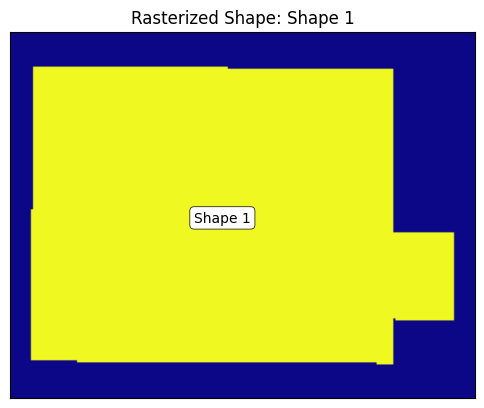

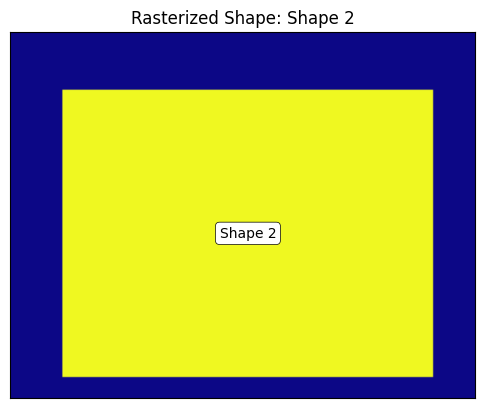

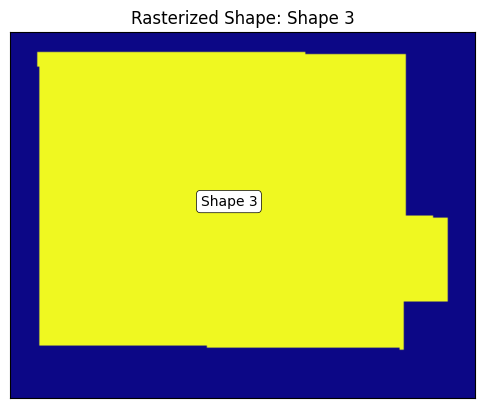

In [44]:
# --- Step 1: Load and reproject data ---
# Make sure your data is in a GeoDataFrame
gdf = gpd.GeoDataFrame({
    'name': ['Shape 1', 'Shape 2', 'Shape 3'],
    'geometry': [
        Polygon([(-118.1175548, 33.8825014), (-118.1175544, 33.8824310), (-118.1175226, 33.8824311),
                 (-118.1175225, 33.8823938), (-118.1175540, 33.8823937), (-118.1175540, 33.8823747),
                 (-118.1177406, 33.8823741), (-118.1177412, 33.8825008), (-118.1175548, 33.8825014)]),
        Polygon([(-118.1177255, 33.8824911), (-118.1175342, 33.8824926), (-118.1175328, 33.8823689),
                 (-118.1177241, 33.8823674), (-118.1177255, 33.8824911)]),
        Polygon([(-118.1177359, 33.8823811), (-118.1177386, 33.8825070), (-118.1175488, 33.8825081),
                 (-118.1175482, 33.8824380), (-118.1175261, 33.8824381), (-118.1175258, 33.8824013),
                 (-118.1175480, 33.8824012), (-118.1175479, 33.8823811), (-118.1177359, 33.8823811)])
    ]
}, crs='EPSG:4326')  # WGS 84


# --- Step 2: Reproject to UTM Zone 11N ---
gdf = gdf.to_crs(epsg=32611)
print(gdf)

# --- Step 3: Compute bounding box ---
xmin, ymin, xmax, ymax = gdf.total_bounds
print(f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

# --- Apply padding to bounding box ---
xmin -= 1.0  # Add padding to the left
ymin -= 1.0  # Add padding to the bottom   
xmax += 1.0  # Add padding to the right 
ymax += 1.0  # Add padding to the top

# --- Step 4: Define resolution in meters ---
resolution = 0.1  # 1 meter per pixel
nx = int((xmax - xmin) / resolution)
ny = int((ymax - ymin) / resolution)
print(f"Raster size: {nx} x {ny}")

# --- Step 5: Create an affine transform for rasterization ---
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

# --- Step 6: Loop through each shape and rasterize individually ---
for i, row in gdf.iterrows():
    shape = row.geometry
    name = row['name']

    # Create an empty raster for the current shape
    pa = np.zeros((ny, nx), dtype=np.uint8)

    # Rasterize only the current shape
    r = features.rasterize(
        [(mapping(shape), 1)],  # Assign pixel value 1 to this shape
        out_shape=(ny, nx),
        transform=transform
    )

    # Store rasterized shape in the raster array
    pa[r > 0] = 1  # Set rasterized pixels to 1 for visualization

    # --- Step 7: Plot the raster for the current shape ---
    plt.figure(figsize=(6, 6))

    # Plot the rasterized shape
    plt.imshow(pa, cmap='plasma', origin='upper', extent=[xmin, xmax, ymin, ymax])

    # Add the label at the centroid
    centroid = shape.centroid
    plt.text(
        centroid.x, centroid.y, f"{name}", fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
    )

    plt.title(f"Rasterized Shape: {name}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
#Export out the new rasterized shapes WKT

Raster size: 222 x 175


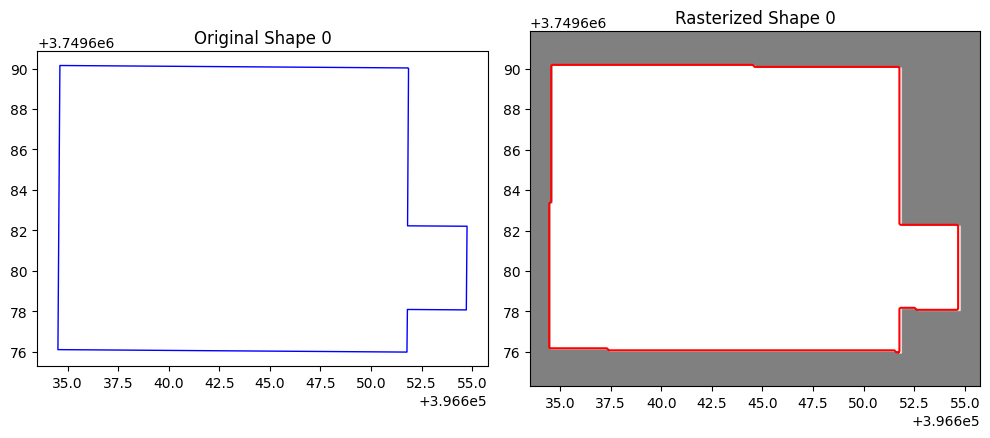

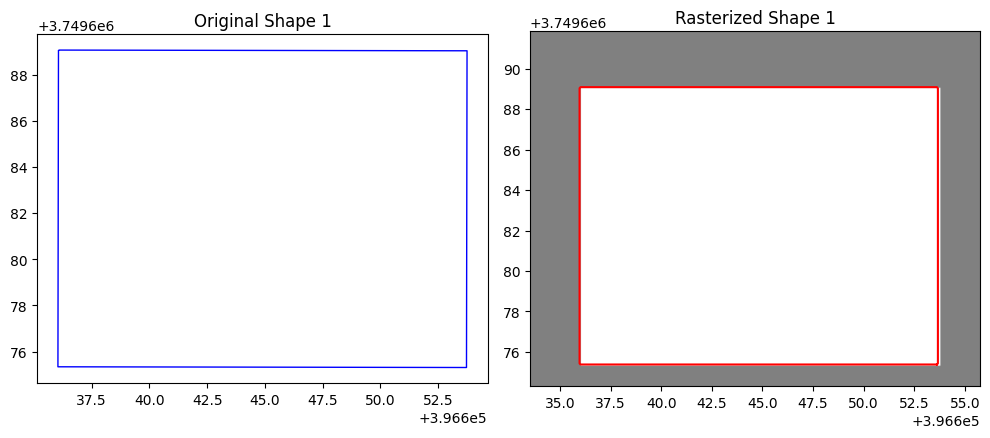

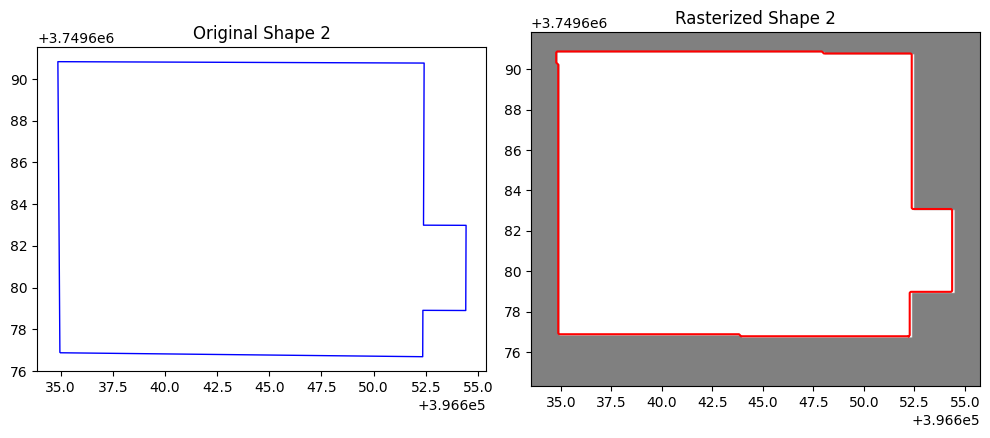

✅ Exported 3 rasterized polygons to 'rasterized_polygons.wkt'


d:\Program_Files\miniforge3\envs\playgound\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 'POLYGON ((-118.11755462498668 33.882374702106084, -118.11755570615455 33.882374692299486, -118.11755625261748 33.88237513826477, -118.1175567990804 33.88237558423005, -118.1175578802483 33.88237557442341, -118.11755896141618 33.88237556461679, -118.11756004258405 33.88237555481013, -118.11756112375193 33.88237554500348, -118.11756220491982 33.88237553519681, -118.1175632860877 33.88237552539014, -118.11756436725557 33.882375515583455, -118.11756544842345 33.882375505776764, -118.11756652959133 33.88237549597005, -118.11756761075922 33.88237548616335, -118.11756869192709 33.88237547635662, -118.11756977309497 33.882375466549895, -118.11757085426284 33.88237545674315, -118.11757193543072 33.8823754469364, -118.1175730165986 33.882375437129646, -118.11757409776646 33.88237542732288, -118.11757517893436 33.88237541751609, -118.11757626010221 33.882375407709304, -118.1175773412701 33.8823

In [78]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import affine_transform
from skimage.measure import find_contours
import shapely.wkt
import matplotlib.pyplot as plt
from rasterio import Affine, features
from rasterio.transform import array_bounds

# Reproject to UTM Zone 11N (EPSG:32611)
gdf.to_crs(epsg=32611, inplace=True)

# Get bounding box for all shapes
xmin, ymin, xmax, ymax = gdf.total_bounds

# Get the centroid of the original geometry
centroid = shape.centroid
centroid_x, centroid_y = centroid.x, centroid.y

# --- Apply padding to bounding box ---
xmin -= 1.0  # Add padding to the left
ymin -= 1.0  # Add padding to the bottom   
xmax += 1.0  # Add padding to the right 
ymax += 1.0  # Add padding to the top

# --- Step 4: Define resolution in meters ---
resolution = 0.1  # 1 meter per pixel
nx = int((xmax - xmin) / resolution)
ny = int((ymax - ymin) / resolution)
print(f"Raster size: {nx} x {ny}")

# --- Step 5: Create an affine transform for rasterization ---
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)
# Adjust the raster grid so that it aligns with the centroid
#transform = Affine.translation(centroid_x - nx * resolution / 2, centroid_y + ny * resolution / 2) * Affine.scale(resolution, -resolution)

# --- Prepare to collect WKT results ---
wkt_list = []
# Create an empty list to hold contour polygons
contour_polygons = []

for i, row in gdf.iterrows():
    shape = row.geometry  # Get geometry directly from gdf
    name = row['name']    # Get name if needed

    # Create an empty raster for the current shape
    pa = np.zeros((ny, nx), dtype=np.uint8)

 # Round coordinates to nearest grid point to snap geometry
    #shape = affine_transform(shape, [1, 0, 0, 1, 0.5, 0.5])  # Shifts geometry by 0.5 to snap to center of pixel


    # Rasterize only the current shape
    if shape.is_valid and not shape.is_empty:
        r = features.rasterize(
            [(mapping(shape), 1)],  # Assign pixel value 1 to this shape
            out_shape=(ny, nx),
            transform=transform, 
            fill=0
        )

        # Store rasterized shape in the raster array
        pa[r > 0] = 1
    
    
    # --- Extract contours for the rasterized shape ---
    contours = find_contours(pa)  # Threshold 0.5 to capture shape boundaries
    
    # --- Convert each contour to a polygon ---
    for contour in contours:
        # Convert from (row, column) to (x, y) using the affine transformation
        #coords = [(transform * (x, y)) for y, x in contour]  # Fix row/column inversion
        coords = [(transform * (col, row)) for row, col in contour] 
        
        # Create the polygon from the contour
        polygon = Polygon(coords)

        
        # Ensure the polygon is valid and not empty
        if polygon.is_valid and not polygon.is_empty:
            wkt_list.append(shapely.wkt.dumps(polygon))
            # Add to list with attributes if needed
            contour_polygons.append({'geometry': polygon, 'name': name})

    # --- Plot original and rasterized shape side by side ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot original shape
    gdf.iloc[[i]].plot(ax=axes[0], color='none', edgecolor='blue')
    axes[0].set_title(f"Original Shape {i}")
    axes[0].set_aspect('equal')

    # Plot rasterized shape and contours
    extent = array_bounds(ny, nx, transform)  # Get correct extent
    axes[1].imshow(pa, cmap='gray', origin='upper', extent=[xmin, xmax, ymin, ymax], alpha=0.5)

    for polygon in contours:
        coords = [(transform * (x, y)) for y, x in polygon]
        p = Polygon(coords)
        if p.is_valid:
            x, y = p.exterior.xy
            axes[1].plot(x, y, color='red')

    axes[1].set_title(f"Rasterized Shape {i}")
    axes[1].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# --- Save WKT results to file ---
with open('rasterized_polygons.txt', 'w') as f:
    for wkt in wkt_list:
        f.write(wkt + '\n')

print(f"✅ Exported {len(wkt_list)} rasterized polygons to 'rasterized_polygons.wkt'")

# Create a GeoDataFrame with polygons
gdf_contours = gpd.GeoDataFrame(contour_polygons, crs="EPSG:32611")

# ✅ Reproject to EPSG:4326 (WGS84)
gdf_contours.to_crs(epsg=4326, inplace=True)

# Save WKT to file without manual transformation
gdf_contours['wkt'] = gdf_contours.geometry.apply(lambda geom: geom.wkt)

# Export to file
gdf_contours[['name','wkt']].to_csv('rasterized_polygons_10cm.csv', index=False, header=False)

#Save gdf to shapefile
gdf_contours.to_file('rasterized_polygons_10cm.shp')




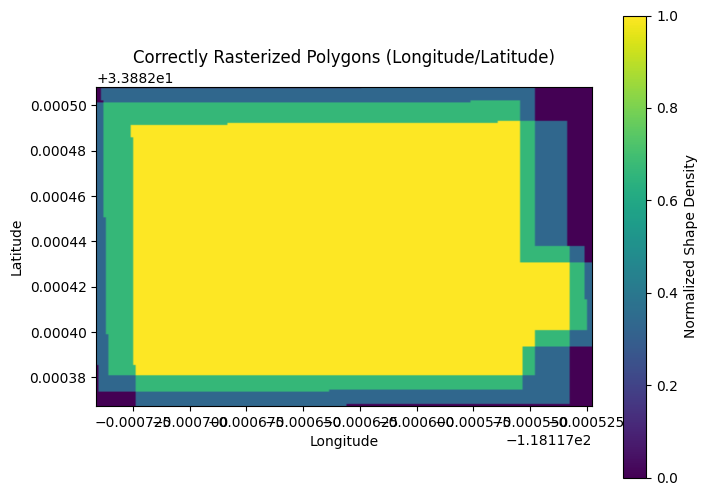

In [103]:
# Compute bounding box
xmin, ymin, xmax, ymax = (
    min(p.bounds[0] for p in structures), min(p.bounds[1] for p in structures),
    max(p.bounds[2] for p in structures), max(p.bounds[3] for p in structures)
)

# # Define raster resolution (degrees per pixel)
# nx, ny = 500, 500  # Higher resolution for better visualization
# xres = (xmax - xmin) / nx
# yres = (ymax - ymin) / ny

# Define degree-per-meter resolution at 33.88° latitude
lat_res = 0.0000009      # ~1 meter per pixel in latitude
lon_res = 0.00000109     # ~1 meter per pixel in longitude at 33.88° latitude

# Calculate raster dimensions
nx = int((xmax - xmin) / lon_res)
ny = int((ymax - ymin) / lat_res)

# Create affine transform for WGS 84 (still degrees, but 1-meter equivalent)
transform = Affine.translation(xmin, ymax) * Affine.scale(lon_res, -lat_res)
## Create an affine transform for the raster
#transform = Affine.translation(xmin, ymax) * Affine.scale(xres, -yres)

# Create an empty raster
pa = np.zeros((ny, nx), dtype=float)

# Rasterize each shape
for s in structures:
    r = features.rasterize([mapping(s)], out_shape=(ny, nx), transform=transform)
    pa[r > 0] += 1

# Normalize the raster
pa /= len(structures)

# Plot the raster
plt.figure(figsize=(8, 6))
plt.imshow(pa, cmap='viridis', origin='upper', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label="Normalized Shape Density")
plt.title("Correctly Rasterized Polygons (Longitude/Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

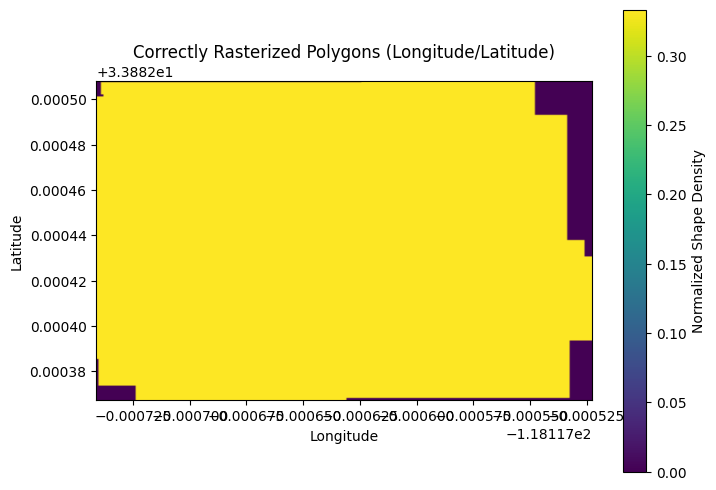

In [ ]:
# Compute bounding box
xmin, ymin, xmax, ymax = (
    min(p.bounds[0] for p in structures), min(p.bounds[1] for p in structures),
    max(p.bounds[2] for p in structures), max(p.bounds[3] for p in structures)
)

# # Define raster resolution (degrees per pixel)
# nx, ny = 500, 500  # Higher resolution for better visualization
# xres = (xmax - xmin) / nx
# yres = (ymax - ymin) / ny

# Define degree-per-meter resolution at 33.88° latitude
lat_res = 0.0000009      # ~1 meter per pixel in latitude
lon_res = 0.00000109     # ~1 meter per pixel in longitude at 33.88° latitude

# Calculate raster dimensions
nx = int((xmax - xmin) / lon_res)
ny = int((ymax - ymin) / lat_res)

# Create affine transform for WGS 84 (still degrees, but 1-meter equivalent)
transform = Affine.translation(xmin, ymax) * Affine.scale(lon_res, -lat_res)
## Create an affine transform for the raster
#transform = Affine.translation(xmin, ymax) * Affine.scale(xres, -yres)

# Create an empty raster
pa = np.zeros((ny, nx), dtype=float)

# Rasterize each shape
for i, s in enumerate(structures, start=1):
    r = features.rasterize([mapping(s), i], out_shape=(ny, nx), transform=transform)
    pa[r > 0] = i

# Normalize the raster
pa /= len(structures)

# Plot the raster
plt.figure(figsize=(8, 6))
plt.imshow(pa, cmap='viridis', origin='upper', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label="Normalized Shape Density")
plt.title("Correctly Rasterized Polygons (Longitude/Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [67]:
# Mask: Include only non-zero values
mask = pa > 0

# Extract rasterized shapes to polygons
shapes_generator = shapes(pa, mask=mask, transform=transform)

# Convert raster shapes to polygons
polygons = [shape(geom) for geom, value in shapes_generator if value > 0]

# Create a GeoDataFrame with rasterized shapes
gdf_rasterized = gpd.GeoDataFrame({'geometry': polygons, 'value': [1] * len(polygons)})

# Set CRS to WGS 84 (EPSG:4326)
gdf_rasterized.set_crs(epsg=4326, inplace=True)

# Save to shapefile
raster_to_shapefile = r"D:\gis\rasterized_shapes_output.shp"
gdf_rasterized.to_file(raster_to_shapefile, driver='ESRI Shapefile')

print(f"Rasterized polygons saved to: {raster_to_shapefile}")

Rasterized polygons saved to: D:\gis\rasterized_shapes_output.shp


In [56]:
print(type(shapes))

<class 'list'>


In [62]:
# Mask to ignore zeros (background)
mask = pa > 0

# Extract rasterized shapes with IDs
shapes_generator = shapes(pa, mask=mask, transform=transform)

# Create list of polygons with their associated ID
polygon_list = []
polygon_ids = []

for geom, value in shapes_generator:
    if value > 0:
        polygon_list.append(shape(geom))
        polygon_ids.append(value)

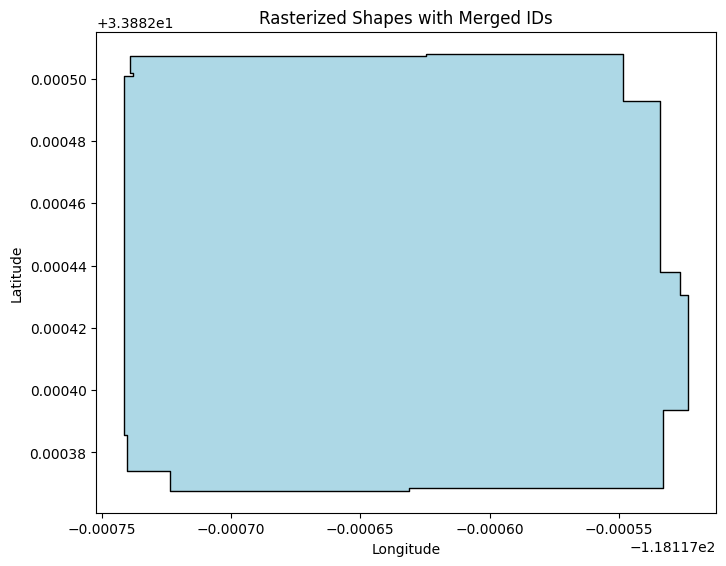

In [ ]:
# Compute bounding box
xmin, ymin, xmax, ymax = (
    min(p.bounds[0] for p in structures), min(p.bounds[1] for p in structures),
    max(p.bounds[2] for p in structures), max(p.bounds[3] for p in structures)
)

# # Define raster resolution (degrees per pixel)
# nx, ny = 500, 500  # Higher resolution for better visualization
# xres = (xmax - xmin) / nx
# yres = (ymax - ymin) / ny

# Define degree-per-meter resolution at 33.88° latitude
lat_res = 0.0000009      # ~1 meter per pixel in latitude
lon_res = 0.00000109     # ~1 meter per pixel in longitude at 33.88° latitude

# Calculate raster dimensions
nx = int((xmax - xmin) / lon_res)
ny = int((ymax - ymin) / lat_res)

# Create affine transform for WGS 84 (still degrees, but 1-meter equivalent)
transform = Affine.translation(xmin, ymax) * Affine.scale(lon_res, -lat_res)
## Create an affine transform for the raster
#transform = Affine.translation(xmin, ymax) * Affine.scale(xres, -yres)

# Create an empty raster
pa = np.zeros((ny, nx), dtype=float)

# Rasterize each shape
for i, s in enumerate(structures, start=1):
    r = features.rasterize([mapping(s), i], out_shape=(ny, nx), transform=transform)
    pa[r > 0] = i

# Normalize the raster
pa /= len(structures)

# Plot the raster
plt.figure(figsize=(8, 6))
plt.imshow(pa, cmap='viridis', origin='upper', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label="Normalized Shape Density")
plt.title("Correctly Rasterized Polygons (Longitude/Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

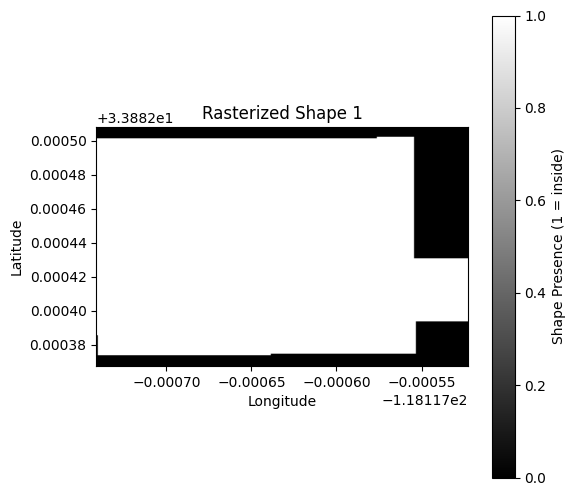

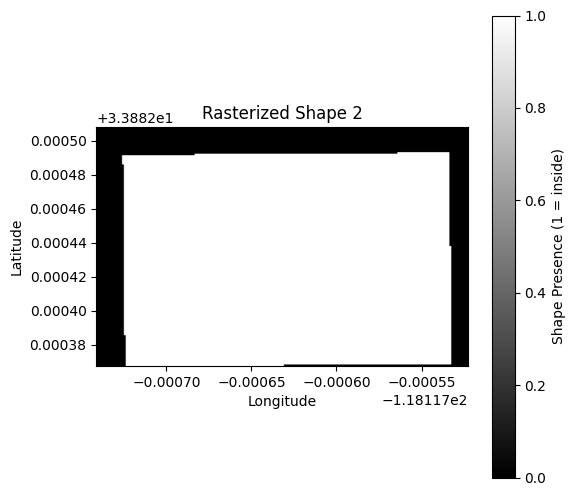

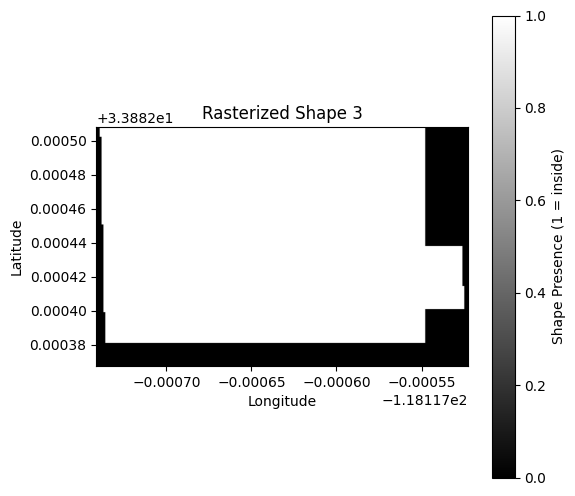

In [70]:
# Loop through each shape and rasterize individually
for i, shape in enumerate(structures, start=1):
    # Create an empty raster for the current shape
    pa = np.zeros((ny, nx), dtype=np.uint8)
    
    # Rasterize only the current shape
    r = features.rasterize(
        [(mapping(shape), 1)],  # Assign pixel value 1 to this shape
        out_shape=(ny, nx),
        transform=transform
    )
    
    # Store rasterized shape in the raster array
    pa[r > 0] = 1  # Set rasterized pixels to 1 for visualization
    
    # Plot the raster for the current shape
    plt.figure(figsize=(6, 6))
    plt.imshow(pa, cmap='gray', origin='upper', extent=[xmin, xmax, ymin, ymax])
    plt.title(f"Rasterized Shape {i}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Shape Presence (1 = inside)")
    plt.show()